In [47]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

cudnn.benchmark = True
plt.ion()   # interactive mode
# Creates a runs/baseline_resnet18_dataaugmented folder
writer = SummaryWriter("TensorBoard/runs/baseline_resnet18_with_dataaugmentation")

## Load Data

In [48]:
# Cropping and normalization for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [49]:
# Data augmentation and normalization for training set
data_augmentation = transforms.Compose([
        transforms.RandomCrop(500),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [50]:
data_dir = '../Datasets/Kaggle/flower-data'
# A map with keys "train" and "val" and values being images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
augmented_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_augmentation)
image_datasets['train'] = torch.utils.data.ConcatDataset([image_datasets['train'], augmented_train_dataset])
# A map with keys "train" and "val" and values being DataLoaders. A DataLoader is an iterable. 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].datasets[0].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [51]:
print(image_datasets)
print(dataset_sizes)

{'train': <torch.utils.data.dataset.ConcatDataset object at 0x7fd9997eb730>, 'val': Dataset ImageFolder
    Number of datapoints: 818
    Root location: ../Datasets/Kaggle/flower-data/val
    StandardTransform
Transform: Compose(
               CenterCrop(size=(500, 500))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
{'train': 13104, 'val': 818}


## Visualize data

In [52]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

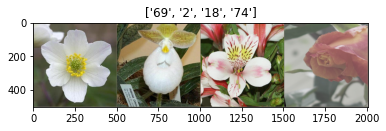

In [53]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch for the visualization purposes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Test

In [54]:
inputs, classes = next(iter(dataloaders["train"]))
print(classes)
print(len(dataloaders["val"]))

tensor([26,  6, 97, 82])
205


## Train the model

In [55]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            batch_index = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                
                # Write the loss and accuracy to TensorBoard
                writer.add_scalar('Loss/' + phase, batch_loss, epoch * len(dataloaders[phase]) + batch_index)
                writer.add_scalar('Accuracy/' + phase, batch_corrects / inputs.size(0), epoch * len(dataloaders[phase]) + batch_index)
                
                batch_index += 1
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.flush()
    return model

## Visualize the model predictions

In [56]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetune the ResNet18

In [57]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

num_classes = 102
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [58]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|█████████████████| 3276/3276 [10:09<00:00,  5.37it/s]


train Loss: 2.0711 Acc: 0.5317


100%|███████████████████| 205/205 [00:15<00:00, 13.21it/s]


val Loss: 0.3201 Acc: 0.9218

Epoch 1/9
----------


100%|█████████████████| 3276/3276 [10:09<00:00,  5.37it/s]


train Loss: 0.6423 Acc: 0.8578


100%|███████████████████| 205/205 [00:14<00:00, 14.16it/s]


val Loss: 0.1632 Acc: 0.9560

Epoch 2/9
----------


100%|█████████████████| 3276/3276 [10:09<00:00,  5.37it/s]


train Loss: 0.3782 Acc: 0.9174


100%|███████████████████| 205/205 [00:14<00:00, 13.88it/s]


val Loss: 0.1187 Acc: 0.9768

Epoch 3/9
----------


100%|█████████████████| 3276/3276 [10:09<00:00,  5.37it/s]


train Loss: 0.2585 Acc: 0.9457


100%|███████████████████| 205/205 [00:14<00:00, 14.22it/s]


val Loss: 0.1143 Acc: 0.9743

Epoch 4/9
----------


100%|█████████████████| 3276/3276 [10:10<00:00,  5.37it/s]


train Loss: 0.1961 Acc: 0.9589


100%|███████████████████| 205/205 [00:14<00:00, 14.20it/s]


val Loss: 0.0834 Acc: 0.9890

Epoch 5/9
----------


100%|█████████████████| 3276/3276 [10:11<00:00,  5.36it/s]


train Loss: 0.1700 Acc: 0.9634


100%|███████████████████| 205/205 [00:14<00:00, 14.20it/s]


val Loss: 0.0818 Acc: 0.9841

Epoch 6/9
----------


100%|█████████████████| 3276/3276 [10:16<00:00,  5.31it/s]


train Loss: 0.1209 Acc: 0.9749


100%|███████████████████| 205/205 [00:14<00:00, 14.21it/s]


val Loss: 0.0902 Acc: 0.9817

Epoch 7/9
----------


100%|█████████████████| 3276/3276 [10:09<00:00,  5.37it/s]


train Loss: 0.0888 Acc: 0.9831


100%|███████████████████| 205/205 [00:14<00:00, 14.15it/s]


val Loss: 0.0704 Acc: 0.9890

Epoch 8/9
----------


100%|█████████████████| 3276/3276 [10:12<00:00,  5.35it/s]


train Loss: 0.0648 Acc: 0.9902


100%|███████████████████| 205/205 [00:14<00:00, 14.16it/s]


val Loss: 0.0679 Acc: 0.9890

Epoch 9/9
----------


100%|█████████████████| 3276/3276 [10:12<00:00,  5.35it/s]


train Loss: 0.0649 Acc: 0.9882


100%|███████████████████| 205/205 [00:14<00:00, 14.17it/s]

val Loss: 0.0656 Acc: 0.9890

Training complete in 104m 18s
Best val Acc: 0.988998


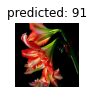

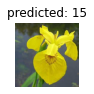

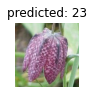

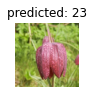

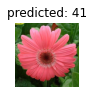

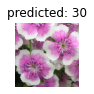

In [59]:
visualize_model(model_ft)

## Save Model

In [60]:
torch.save(model_ft.state_dict(), "saved-models/baseline_resnet18_10epochs_with_dataaugmentation.pth")

## Close the TensorBoard summary writer

In [61]:
writer.close()

## Reference

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html